In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.5
KerasCV: 0.8.2


In [4]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 1 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [5]:
keras.utils.set_random_seed(CFG.seed)

## Load in data

In [6]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [7]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0.0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


## Set binary class label

In [8]:
df['seizure_binary'] = np.where(df.expert_consensus == 'Seizure',1,0)

In [9]:
df.seizure_binary.value_counts()

seizure_binary
0    85867
1    20933
Name: count, dtype: int64

## Create cross val splits

In [10]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["seizure_binary"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2705  2824  2901  3715  3987    3897  3249  4401  1178  4189  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      1765  2317  3314    3470  2201  3258  5484  3117  3756    4295  

[1 rows x 30 columns]

## Data processing

In [11]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Create augmenter (not used for now) and build dataset

In [12]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [13]:
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.seizure_binary.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.seizure_binary.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 8950 | Num Valid: 2188


## Start modeling

In [14]:
#baseline model: predict dominant class
accuracies = []
for fold in df.fold.unique():
    train = df[df.fold != fold]
    val = df[df.fold == fold]
    if np.mean(train.seizure_binary) >= 0.5:
        pred = 1
    else:
        pred = 0
    accuracy = sum(np.where(val.seizure_binary == pred,1,0))/len(val)
    accuracies.append(accuracy)
print('crossval accuracies:',accuracies)
print('mean crossval accuracy:',np.mean(accuracies))

crossval accuracies: [0.8057527927276017, 0.809474182851729, 0.8054321234210395, 0.839789463964172, 0.7602210954273446]
mean crossval accuracy: 0.8041339316783773


In [15]:
LOSS = keras.losses.BinaryCrossentropy()

In [16]:
#model 2: simple logistic regression
tf.keras.backend.clear_session()

model = keras.Sequential()

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(
  units=1,                     
  use_bias=True,               
  activation="sigmoid"         
))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(loss='binary_crossentropy', 
            optimizer=optimizer, 
            metrics=[LOSS])

In [17]:
history = model.fit(
  train_ds, 
  epochs=5,
  steps_per_epoch=len(train_df)//CFG.batch_size,
  validation_data=valid_ds, 
  verbose=CFG.verbose           
  )

Epoch 1/5
  4/139 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - binary_crossentropy: 242.4768 - loss: 242.4768

I0000 00:00:1712506429.633720     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 47s 323ms/step - binary_crossentropy: 827.0742 - loss: 827.0742 - val_binary_crossentropy: 648.3947 - val_loss: 648.3947
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - binary_crossentropy: 626.3204 - loss: 626.3204 - val_binary_crossentropy: 2152.3977 - val_loss: 2152.3977
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - binary_crossentropy: 646.5510 - loss: 646.5510 - val_binary_crossentropy: 728.5466 - val_loss: 728.5466
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - binary_crossentropy: 513.7370 - loss: 513.7370 - val_binary_crossentropy: 1548.4016 - val_loss: 1548.4016
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - binary_crossentropy: 630.8018 - loss: 630.8018 - val_binary_crossentropy: 222.6222 - val_loss: 222.6222


In [18]:
from sklearn.metrics import accuracy_score,f1_score
val_preds = np.rint(model.predict(valid_ds))

print('val accuracy:',accuracy_score(valid_labels,val_preds))
print('val f1:',f1_score(valid_labels,val_preds))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
val accuracy: 0.2129798903107861
val f1: 0.15588235294117647


**Jailynne Model**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer

model = Sequential([
    InputLayer(shape=(CFG.image_size[0], CFG.image_size[1], 3)),  
    Conv2D(16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_steps=len(valid_df) // CFG.batch_size,
    verbose=CFG.verbose
)


Epoch 1/13


2024-04-07 16:29:47.874970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 8.06233, expected 7.1186
2024-04-07 16:29:47.875028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.45623, expected 6.5125
2024-04-07 16:29:47.875044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.87881, expected 6.93508
2024-04-07 16:29:47.875061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 8.40568, expected 7.46195
2024-04-07 16:29:47.875076: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.7167, expected 6.77297
2024-04-07 16:29:47.875086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.94927, expected 7.00554
2024-04-07 16:29:47.875097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.85259, expected 5.90886
2024-04-07 16:29:47.875108: E external/local_xla/xla/servi

139/139 ━━━━━━━━━━━━━━━━━━━━ 47s 202ms/step - accuracy: 0.7043 - loss: 2.9982 - val_accuracy: 0.8125 - val_loss: 0.6407
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7401 - loss: 0.5251

2024-04-07 16:30:55.646185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 118793: 3.88607, expected 3.35474
2024-04-07 16:30:55.646306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 121186: 4.31261, expected 3.78128
2024-04-07 16:30:55.646325: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 121187: 4.23125, expected 3.69992
2024-04-07 16:30:55.646348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 121977: 4.25937, expected 3.72804
2024-04-07 16:30:55.646372: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 123091: 3.78513, expected 3.2538
2024-04-07 16:30:55.646415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 126567: 4.28531, expected 3.75398
2024-04-07 16:30:55.646434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 127167: 4.04113, expected 3.5098
2024-04-07 16:30:55.64

139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - accuracy: 0.7401 - loss: 0.5251 - val_accuracy: 0.7500 - val_loss: 5.7496
Epoch 3/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.7678 - loss: 0.5041 - val_accuracy: 0.8258 - val_loss: 0.5694
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.7490 - loss: 0.4540 - val_accuracy: 0.8333 - val_loss: 0.6042
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.7507 - loss: 0.4296 - val_accuracy: 0.8424 - val_loss: 0.4384
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.7552 - loss: 0.4344 - val_accuracy: 0.8333 - val_loss: 0.6922
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.7644 - loss: 0.4527 - val_accuracy: 0.8327 - val_loss: 0.3874
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.7576 - loss: 0.4117 - val_accuracy: 0.7500 - val_loss: 1.9208
Epoch 9/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.7321 - loss: 0.4264 - val

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_predictions = model.predict(valid_ds, batch_size=32)
val_predictions = np.round(val_predictions).astype(int)

# True labels
true_labels = valid_labels 

print(classification_report(true_labels, val_predictions))
print(confusion_matrix(true_labels, val_predictions))


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
              precision    recall  f1-score   support

           0       0.11      0.01      0.01      1783
           1       0.15      0.77      0.25       405

    accuracy                           0.15      2188
   macro avg       0.13      0.39      0.13      2188
weighted avg       0.11      0.15      0.06      2188

[[  11 1772]
 [  92  313]]


**Addressing Class Imbalance**

In [39]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Configure the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_data=valid_ds,
    validation_steps=len(valid_df) // CFG.batch_size,
    class_weight=class_weight_dict,  
    verbose=CFG.verbose)

Epoch 1/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.7491 - loss: 0.7055 - val_accuracy: 0.8148 - val_loss: 0.4800
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7346 - loss: 0.6906

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy: 0.7346 - loss: 0.6905 - val_accuracy: 0.8333 - val_loss: 0.4512
Epoch 3/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - accuracy: 0.7627 - loss: 0.6352 - val_accuracy: 0.8148 - val_loss: 0.4871
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - accuracy: 0.7397 - loss: 0.6469 - val_accuracy: 0.8333 - val_loss: 0.4566
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - accuracy: 0.7433 - loss: 0.6204 - val_accuracy: 0.8148 - val_loss: 0.4977
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.7423 - loss: 0.6129 - val_accuracy: 0.8333 - val_loss: 0.4646
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.7511 - loss: 0.5948 - val_accuracy: 0.8148 - val_loss: 0.5088
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 38s 276ms/step - accuracy: 0.7446 - loss: 0.5942 - val_accuracy: 0.8333 - val_loss: 0.4732
Epoch 9/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - accuracy: 0.7326 - loss: 0.6076 - val

**Data augmentation**

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = {
    'rotation_range': 20,  # degrees
    'width_shift_range': 0.2,  # fraction of total width
    'height_shift_range': 0.2,  # fraction of total height
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'nearest'
}

image_data_generator = ImageDataGenerator(**data_gen_args)


In [43]:
def augment_image(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly flip the image vertically
    image = tf.image.random_flip_up_down(image)

    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


In [44]:
# Apply the augmentation only to the training dataset
augmented_train_ds = train_ds.map(augment_image)


In [45]:
history = model.fit(
    augmented_train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_steps=len(valid_df) // CFG.batch_size
)


Epoch 1/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 76s 512ms/step - accuracy: 0.7485 - loss: 0.5415 - val_accuracy: 0.8130 - val_loss: 0.5367
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 502ms/step - accuracy: 0.7350 - loss: 0.5189 - val_accuracy: 0.8333 - val_loss: 0.4490
Epoch 3/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 518ms/step - accuracy: 0.7573 - loss: 0.5526 - val_accuracy: 0.1903 - val_loss: 136.1108
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 577ms/step - accuracy: 0.7377 - loss: 0.5083 - val_accuracy: 0.1667 - val_loss: 571.5210
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 512ms/step - accuracy: 0.7399 - loss: 0.5035 - val_accuracy: 0.1893 - val_loss: 1393.8011
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 495ms/step - accuracy: 0.7442 - loss: 0.4987 - val_accuracy: 0.1667 - val_loss: 1544.7036
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 513ms/step - accuracy: 0.7499 - loss: 0.4977 - val_accuracy: 0.1898 - val_loss: 1894.5420
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 501ms/step - accuracy: 0.7

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


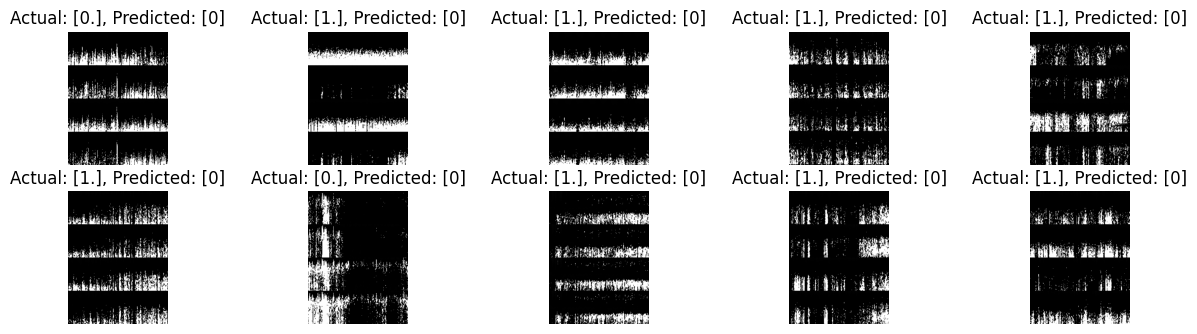

In [52]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display_predictions(dataset, model, num_images=10):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = np.round(preds).astype(int)
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(f"Actual: {labels[i].numpy()}, Predicted: {preds[i]}")
            plt.axis('off')
    plt.show()

display_predictions(valid_ds, model, num_images=10)


In [53]:
# Evaluate the model on the entire validation dataset
val_loss, val_accuracy = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

from sklearn.metrics import classification_report

y_true = np.concatenate([y for x, y in valid_ds], axis=0)
y_pred = model.predict(valid_ds)
y_pred = np.round(y_pred).astype(int)

print(classification_report(y_true, y_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.1884 - loss: 1905.7465
Validation Loss: 1913.1136474609375
Validation Accuracy: 0.18967093527317047
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
              precision    recall  f1-score   support

         0.0       0.19      1.00      0.31       405
         1.0       1.00      0.01      0.01      1783

    accuracy                           0.19      2188
   macro avg       0.59      0.50      0.16      2188
weighted avg       0.85      0.19      0.07      2188



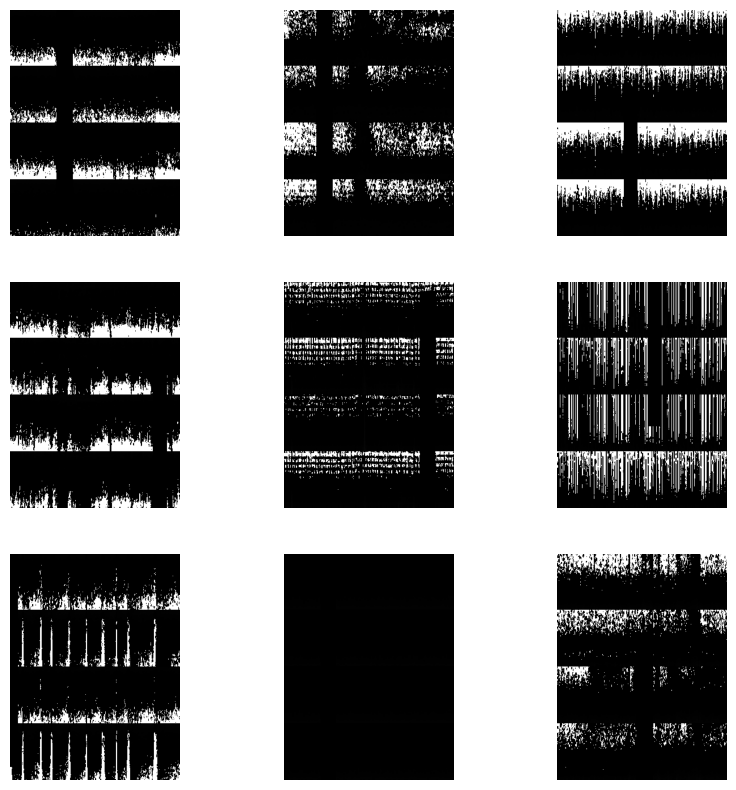

Epoch 1/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 63s 402ms/step - accuracy: 0.7482 - loss: 0.4769 - val_accuracy: 0.8148 - val_loss: 0.4796
Epoch 2/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 54s 388ms/step - accuracy: 0.7388 - loss: 0.4790 - val_accuracy: 0.8333 - val_loss: 0.4509
Epoch 3/13
  1/139 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7656 - loss: 0.5549

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 56s 408ms/step - accuracy: 0.7620 - loss: 0.4822 - val_accuracy: 0.8148 - val_loss: 0.4793
Epoch 4/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 53s 386ms/step - accuracy: 0.7402 - loss: 0.4801 - val_accuracy: 0.8333 - val_loss: 0.4512
Epoch 5/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 419ms/step - accuracy: 0.7414 - loss: 0.4799 - val_accuracy: 0.8148 - val_loss: 0.4793
Epoch 6/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 54s 388ms/step - accuracy: 0.7420 - loss: 0.4813 - val_accuracy: 0.8333 - val_loss: 0.4513
Epoch 7/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 56s 400ms/step - accuracy: 0.7524 - loss: 0.4821 - val_accuracy: 0.8148 - val_loss: 0.4792
Epoch 8/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 397ms/step - accuracy: 0.7409 - loss: 0.4882 - val_accuracy: 0.8333 - val_loss: 0.4514
Epoch 9/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 429ms/step - accuracy: 0.7247 - loss: 0.4817 - val_accuracy: 0.8148 - val_loss: 0.4792
Epoch 10/13
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 400ms/step - accuracy: 0.7444 - loss: 0.4811 - va

In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define data augmentation function using TensorFlow ops
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Apply the augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize some augmented images
def plot_augmented_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

plot_augmented_images(augmented_train_ds)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model using the augmented dataset
history = model.fit(
    augmented_train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_steps=len(valid_df) // CFG.batch_size
)
